In [2]:
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import sklearn.ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
# import eli5
# from eli5.sklearn import PermutationImportance

%matplotlib inline

C:\Users\csong\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# machine learning
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, r2_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from boruta import BorutaPy
from xgboost import XGBClassifier, XGBRanker
from scipy.stats import skew


# print(__doc__)

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
## Load the data set that got dummified to process feature selection.
train= pd.read_csv('./data/Xing/whole_train_cleaned_30.csv')
test= pd.read_csv('./data/Xing/unique_test_cleaned_30.csv')

X_cv= train.drop(['readmitted','encounter_id','patient_nbr'], axis=1)
y_cv= train['readmitted']



X_test = test.drop(['readmitted','encounter_id','patient_nbr'], axis=1)
y_test = test['readmitted']


print("Dataset: Unique- Drop Patient encounter ID")
print('The shape of the unique train dataset {}'.format(train.shape))
print('The shape of the unique test dataset  {} '.format(test.shape))

Dataset: Unique- Drop Patient encounter ID
The shape of the unique train dataset (69524, 94)
The shape of the unique test dataset  (25902, 94) 


## Feature Importance

Top 10 features are: 
num_lab_procedures
num_medications
time_in_hospital
age
number_inpatient
num_procedures
number_diagnoses
gender_Male
number_outpatient
number_emergency


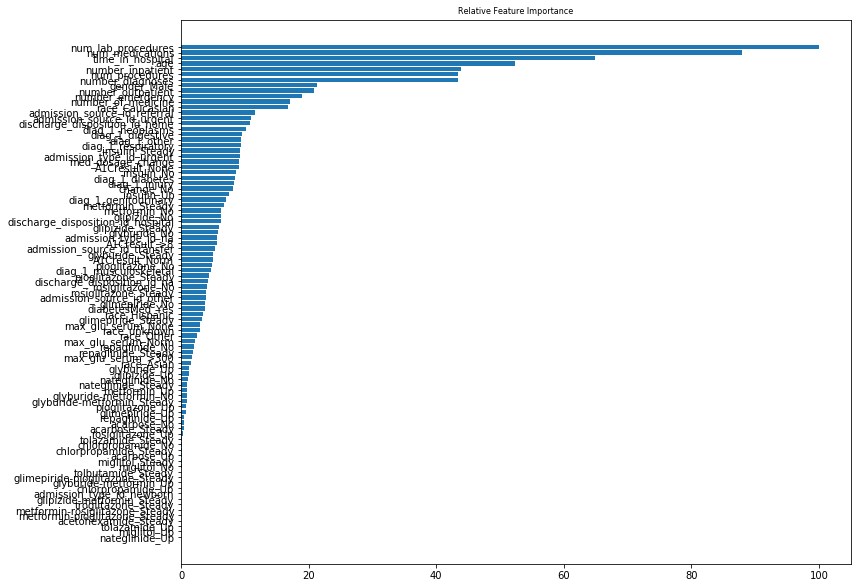

In [5]:
# fit Random Forest model to the cross-validation data
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_cv, y_cv)
importances = forest.feature_importances_

# make importance relative to the max importance
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_cv.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
print ('Top 10 features are: ')
for feature in feature_names_sort[::-1][:10]:
    print (feature)

# plot the result
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names_sort)
plt.title('Relative Feature Importance', fontsize=8)
plt.show()

In [6]:

# make a smaller feature set which only contains the top 6 features
X_cv_top10 = X_cv[['num_lab_procedures', 'num_medications','time_in_hospital','age','number_inpatient', 'number_diagnoses','number_outpatient',
                  'gender_Male','number_emergency']]



## Model Selection

In [7]:
from sklearn.cross_validation import cross_val_score

In [8]:

# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier()
RF_score = cross_val_score(clf1, X_cv, y_cv, cv=10, scoring='accuracy').mean()
RF_score

0.8839249988412835

In [9]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
NB_score = cross_val_score(clf2, X_cv, y_cv, cv=10, scoring='accuracy').mean()
NB_score

0.1222312340066261

In [10]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf3 = LogisticRegression()
LR_score = cross_val_score(clf3, X_cv, y_cv, cv=10, scoring='accuracy').mean()
LR_score

0.8859099687979872

Text(0, 0.5, 'Cross-Validated Accuracy')

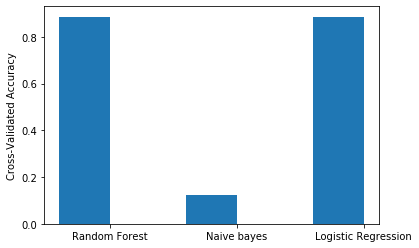

In [11]:
# plot and compare the scores
# LR outperforms the other two a little bit
x_axis = np.arange(3)
y_axis = [RF_score, NB_score, LR_score]
plt.bar(x_axis, y_axis, width=0.4)
plt.xticks(x_axis + 0.4/2., ('Random Forest', 'Naive bayes', 'Logistic Regression'))
plt.ylabel('Cross-Validated Accuracy')

In [12]:
# Logistic Regression on Top 6 features
# still be able to achieve good result with reduced running time
LR_score_top = cross_val_score(clf3, X_cv_top6, y_cv, cv=10, scoring='accuracy').mean()
LR_score_top

NameError: name 'X_cv_top6' is not defined

## Parameter Tuning Using GridSearchCV


Use GridSearchCV to tune parameter C in logistic regression. Smaller C values specify stronger regularization.

In [ ]:
# define the parameter values that should be searched
C_range = np.arange(0.1, 3.1, 0.2)
param_grid = dict(C = C_range)

In [ ]:

# instantiate the grid, fit the grid with data
from sklearn.grid_search import GridSearchCV
clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(X_cv, y_cv)

In [ ]:
# plot the results
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
plt.plot(C_range, grid_mean_scores)
plt.xlabel('Value of C for Logistic Regression')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
# examine the best model
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

## Evaluation Metrics

### Classification accuracy

NULL accuracy: accuracy that could be achieved by always predicting the most frequent class -- 'No Readmission'.

In [ ]:

# examine the class distribution of the testing set
y_test.value_counts()

In [ ]:

# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

In [ ]:

# train a logistic regression model on the cross-validation set with the optimal C parameter
logreg = LogisticRegression(C=grid.best_params_['C'])
logreg.fit(X_cv, y_cv)

In [ ]:
# make class predictions for the testing set 
# calculate accuracy and compare with null accuracy
from sklearn import metrics
y_pred_class = logreg.predict(X_test)
print (metrics.accuracy_score(y_test, y_pred_class))

### Confusion Matrix

Table that describes the performance of a classification model.



True Positives (TP): we correctly predicted that they do have diabetes




True Negatives (TN): we correctly predicted that they don't have diabetes




False Positives (FP): we incorrectly predicted that they do have diabetes (a "Type I error")




False Negatives (FN): we incorrectly predicted that they don't have diabetes (a "Type II error")

In [ ]:

confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print (confusion)

Sensitivity (Recall): How "sensitive" is the classifier to detecting positive instances? TP/(TP+FN)

In [ ]:
print (metrics.recall_score(y_test, y_pred_class))

Specificity: TN/(TN+FP)

In [ ]:

print (TN / float(TN + FP))

False Positive Rate (1 - specificity): FP/(TN+FP)

In [ ]:

print (FP / float(TN + FP))

Precision: TP/(TP+FP)

In [ ]:
print (metrics.precision_score(y_test, y_pred_class))

F1 score: F1 = 2 x precision x recall / (precision + recall)

In [ ]:
print (metrics.f1_score(y_test, y_pred_class))

## Receiver operating characteristic (ROC) curve and area under the curve (AUC)

ROC is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. AUC is the percentage of the ROC plot that is underneath the curve. AUC is useful as a single number summary of classifier performance.

In [ ]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [ ]:

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes readmission')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
# AUC score
print (metrics.roc_auc_score(y_test, y_pred_prob))

In [ ]:
fpr